# Финальный проект: вариант 1#

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from tqdm.auto import tqdm #импортируем все библиотеки, которые понадобятся нам для выполнения проекта

# Задание 1#

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [90]:
reg_data = pd.read_csv('shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('shared/problem1-auth_data.csv', sep=';') #считываем исходные данные и записываем их

In [3]:
reg_data.shape #проверяем размер датафрейма

(1000000, 2)

In [4]:
reg_data = reg_data.drop_duplicates() #удаляем дубликаты, если они есть

In [5]:
reg_data.shape #в датафрейме времени регистрации отсутствуют дубликаты

(1000000, 2)

In [6]:
auth_data.shape #проверяем размер датафрейма

(9601013, 2)

In [7]:
auth_data = auth_data.drop_duplicates() #удаляем дубликаты, если они есть

In [8]:
auth_data.shape #в датафрейме времени захода пользователей в игру отсутствуют дубликаты

(9601013, 2)

In [9]:
reg_data.dtypes #проверяем тип столбцов в датафрейме с помощью метода df.dtypes

reg_ts    int64
uid       int64
dtype: object

In [10]:
auth_data.dtypes #проверяем тип столбцов в датафрейме с помощью метода df.dtypes

auth_ts    int64
uid        int64
dtype: object

In [11]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [12]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Время в датафреймах указано в виде числа секунд, прошедших с 1970 года. Это не удобно для дальнейшего анализа данных, поэтому сконвертируем его в формат даты.

In [13]:
reg_data['reg_ts']   = pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

In [14]:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [15]:
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

Посмотрим, как теперь выглядит формат даты в датафреймах

In [16]:
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [17]:
auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


Так, как нам не нужны в дате часы, минуты и секунды - приведём теперь формат даты к формату год-месяц-день.

In [18]:
reg_data['reg_ts']  = reg_data.reg_ts.dt.to_period("D")
auth_data['auth_ts'] = auth_data.auth_ts.dt.to_period("D")

In [19]:
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [20]:
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


Теперь данные готовы для дальнейшего анализа.

In [21]:
all_dates = reg_data.merge(auth_data, how='right', on='uid') #обьединяем две таблицы в одну по уникальному номеру пользователя

In [22]:
all_dates

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


Получившийся датафрейм довольно большой, так как содержит более 9.5 млн. строк с данными. Проверим, какая была самая ранняя и самая последняя дата регистрации пользователей у данной игры.

In [23]:
all_dates.reg_ts.min()

Period('1998-11-18', 'D')

In [24]:
all_dates.reg_ts.max()

Period('2020-09-23', 'D')

Временной промежуток довольно большой. При рассчёте показателя retention будем использовать данные с регистациями за последние два месяца - за август и сентябрь 2020-го года.

In [25]:
all_dates = all_dates.query('reg_ts >= "2020-08-01" &  reg_ts <= "2020-09-23"')

In [26]:
all_dates

,reg_ts,uid,auth_ts
9428605,2020-08-01,1016863,2020-08-01
9428606,2020-08-01,1016863,2020-08-06
9428607,2020-08-01,1016863,2020-08-11
9428608,2020-08-01,1016863,2020-08-15
9428609,2020-08-01,1016863,2020-08-18
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


In [27]:
cohorts = all_dates.groupby(['reg_ts', 'auth_ts']).agg({'uid':'count'})

In [28]:
cohorts

uid
reg_ts     auth_ts         
2020-08-01 2020-08-01  1507
           2020-08-02    29
           2020-08-03    67
           2020-08-04    65
           2020-08-05    84
...                     ...
2020-09-21 2020-09-22    31
           2020-09-23    49
2020-09-22 2020-09-22  1641
           2020-09-23    14
2020-09-23 2020-09-23  1048

[1485 rows x 1 columns]

In [29]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 0
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [30]:
cohorts

uid  cohort_period
reg_ts     auth_ts                        
2020-08-01 2020-08-01  1507              0
           2020-08-02    29              1
           2020-08-03    67              2
           2020-08-04    65              3
           2020-08-05    84              4
...                     ...            ...
2020-09-21 2020-09-22    31              1
           2020-09-23    49              2
2020-09-22 2020-09-22  1641              0
           2020-09-23    14              1
2020-09-23 2020-09-23  1048              0

[1485 rows x 2 columns]

In [31]:
cohorts_pivot = cohorts.pivot_table(index='reg_ts', columns='cohort_period', values='uid')

In [32]:
cohorts_pivot

cohort_period,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1507.0,29.0,67.0,65.0,84.0,89.0,115.0,96.0,68.0,96.0,...,27.0,21.0,27.0,11.0,14.0,24.0,24.0,18.0,19.0,13.0
2020-08-02,1509.0,39.0,61.0,66.0,78.0,98.0,100.0,91.0,68.0,80.0,...,22.0,16.0,20.0,19.0,20.0,16.0,25.0,21.0,6.0,NaN
2020-08-03,1512.0,26.0,65.0,61.0,84.0,93.0,114.0,80.0,75.0,74.0,...,30.0,27.0,23.0,22.0,23.0,17.0,15.0,14.0,NaN,NaN
2020-08-04,1514.0,31.0,54.0,71.0,79.0,80.0,98.0,78.0,67.0,71.0,...,25.0,26.0,20.0,20.0,22.0,15.0,12.0,NaN,NaN,NaN
2020-08-05,1517.0,39.0,53.0,61.0,87.0,77.0,118.0,93.0,64.0,72.0,...,19.0,24.0,10.0,16.0,16.0,8.0,NaN,NaN,NaN,NaN
2020-08-06,1519.0,26.0,77.0,87.0,85.0,87.0,114.0,92.0,76.0,88.0,...,18.0,17.0,17.0,15.0,17.0,NaN,NaN,NaN,NaN,NaN
2020-08-07,1522.0,33.0,47.0,80.0,81.0,91.0,109.0,94.0,78.0,76.0,...,20.0,22.0,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,1524.0,37.0,73.0,64.0,83.0,83.0,110.0,96.0,60.0,73.0,...,21.0,15.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,1527.0,32.0,60.0,71.0,82.0,108.0,96.0,101.0,68.0,75.0,...,27.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
all_cohorts = cohorts_pivot[0]

In [34]:
user_retention = cohorts_pivot.divide(all_cohorts, axis=0)

In [35]:
user_retention

cohort_period,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1.0,0.019244,0.044459,0.043132,0.055740,0.059058,0.076311,0.063703,0.045123,0.063703,...,0.017916,0.013935,0.017916,0.007299,0.009290,0.015926,0.015926,0.011944,0.012608,0.008626
2020-08-02,1.0,0.025845,0.040424,0.043738,0.051690,0.064944,0.066269,0.060305,0.045063,0.053015,...,0.014579,0.010603,0.013254,0.012591,0.013254,0.010603,0.016567,0.013917,0.003976,NaN
2020-08-03,1.0,0.017196,0.042989,0.040344,0.055556,0.061508,0.075397,0.052910,0.049603,0.048942,...,0.019841,0.017857,0.015212,0.014550,0.015212,0.011243,0.009921,0.009259,NaN,NaN
2020-08-04,1.0,0.020476,0.035667,0.046896,0.052180,0.052840,0.064729,0.051519,0.044254,0.046896,...,0.016513,0.017173,0.013210,0.013210,0.014531,0.009908,0.007926,NaN,NaN,NaN
2020-08-05,1.0,0.025709,0.034937,0.040211,0.057350,0.050758,0.077785,0.061305,0.042189,0.047462,...,0.012525,0.015821,0.006592,0.010547,0.010547,0.005274,NaN,NaN,NaN,NaN
2020-08-06,1.0,0.017117,0.050691,0.057275,0.055958,0.057275,0.075049,0.060566,0.050033,0.057933,...,0.011850,0.011192,0.011192,0.009875,0.011192,NaN,NaN,NaN,NaN,NaN
2020-08-07,1.0,0.021682,0.030880,0.052562,0.053219,0.059790,0.071616,0.061761,0.051248,0.049934,...,0.013141,0.014455,0.014455,0.008541,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,1.0,0.024278,0.047900,0.041995,0.054462,0.054462,0.072178,0.062992,0.039370,0.047900,...,0.013780,0.009843,0.007218,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,1.0,0.020956,0.039293,0.046496,0.053700,0.070727,0.062868,0.066143,0.044532,0.049116,...,0.017682,0.009823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
ur_style = (user_retention
            .style
            .set_caption('Коэффициент удержания (Retention Rate) игроков по дням от даты регистрации игрока\n')  # добавляем подпись
            .background_gradient(cmap='plasma')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту

In [37]:
ur_style

In [38]:
user_retention[1].mean()*100  #Считаем средний retention 1-го дня в процентах

2.0401044945437956

In [39]:
user_retention[7].mean()*100  #Считаем средний retention 7-го дня в процентах

5.909927372069677

In [40]:
user_retention[10].mean()*100  #Считаем средний retention 10-го дня в процентах

5.220270807319787

In [41]:
user_retention[14].mean()*100  #Считаем средний retention 14-го дня в процентах

4.591731145981575

In [42]:
user_retention[21].mean()*100  #Считаем средний retention 21-го дня в процентах

3.892009211194892

In [43]:
user_retention[31].mean()*100  #Считаем средний retention 31-го дня в процентах

2.7359748985924632

In [44]:
user_retention[43].mean()*100  #Считаем средний retention 43-го дня в процентах

1.46048661827691

In [45]:
user_retention[53].mean()*100  #Считаем средний retention 53-го дня в процентах

0.8626410086264101

## Задание 2 ##

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [49]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep=";") #считываем исходные данные о результатах A/B теста

In [50]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [51]:
users = df.groupby('testgroup', as_index=False).agg({'user_id':'nunique'}) #группируем по тестовой группе и 
#считаем кол-во уникальных юзеров в каждой.

In [52]:
users

,testgroup,user_id
0,a,202103
1,b,202667


In [53]:
202103 + 202667 

404770

Полученное количество пользователей в каждой группе совпадает с заявленным в условии.

В 2-х группах пропорции пользователей составляют ~ 50% от общей выборки, пользователи разделены по группам равномерно.

Сформулируем гипотезы для проверки.

##### Нулевая гипотеза(H0) ####
Разницы между средней выручкой на одного пользователя в тестовой и контрольной группе нет.
##### Альтернативная гипотеза(H1) #### 
Разница между средней выручкой на одного пользователя в тестовой и контрольной группе есть.

In [54]:
control = df.query("testgroup == 'a'") #запишем в отдельный датафрейм резльтаты по контрольной группе

In [55]:
control

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [57]:
test = df.query("testgroup == 'b'") #запишем в отдельный датафрейм резльтаты по тестовой группе

In [58]:
test

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


У нас большие выборки. В условии задания было сказано, что в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Это означает, что в большей части строк обеих групп revenue = 0. 

Проверим с помощью процентилей.

In [59]:
control.revenue.describe(percentiles=[.25, .50, .75, .90, .99]).round(2)

count    202103.00
mean         25.41
std         920.77
min           0.00
25%           0.00
50%           0.00
75%           0.00
90%           0.00
99%           0.00
max       37433.00
Name: revenue, dtype: float64

In [60]:
test.revenue.describe(percentiles=[.25, .50, .75, .90, .99]).round(2)

count    202667.00
mean         26.75
std         287.32
min           0.00
25%           0.00
50%           0.00
75%           0.00
90%           0.00
99%           0.00
max        4000.00
Name: revenue, dtype: float64

В обоих группах 99% пользователей не совершили платёжное действие (revenue = 0).

In [61]:
scipy.stats.normaltest(control.revenue) #проверим, как распределены значения в контрольной группе

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [62]:
scipy.stats.normaltest(test.revenue) #проверим, как распределены значения в тестовой группе

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

Значения и в тестовой, и в контрольной группе распределены ненормально.

Text(0, 0.5, 'Прибыль')

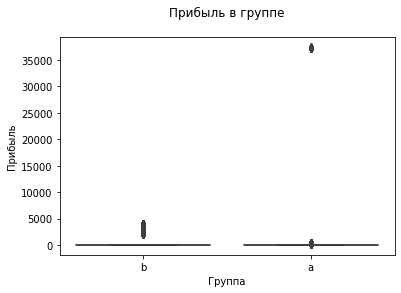

In [63]:
sns.boxplot(x = 'testgroup', y = 'revenue', data = df)
plt.title('Прибыль в группе\n')
plt.xlabel('Группа')
plt.ylabel('Прибыль') #строим боксплот

Видим, все платёжные действия пользователей интерпретируются, как выбросы в данных. Такая концепция нелогична.

С помощью критерия согласия Пирсона проверим, значимы ли различия между группами в количестве платящих пользователей. H0 - между ними нет разницы. H1 - разница есть.

In [64]:
df['pay'] = np.where(df['revenue']==0, 'no_pay', 'pay') #добавим к исходным данным колонку, 
#которая заполнит значениями 'no_pay', 'pay' в зав-ти от того, была оплата юзером или нет.

In [65]:
df

,user_id,revenue,testgroup,pay
0,1,0,b,no_pay
1,2,0,a,no_pay
2,3,0,a,no_pay
3,4,0,b,no_pay
4,5,0,b,no_pay
...,...,...,...,...
404765,404766,0,a,no_pay
404766,404767,0,b,no_pay
404767,404768,231,a,pay
404768,404769,0,a,no_pay


In [66]:
pd.crosstab(df.pay, df.testgroup) #создаем таблицу сопряженности

testgroup,a,b
pay,,
no_pay,200175,200862
pay,1928,1805


In [67]:
from scipy.stats import chi2_contingency, chi2 

In [68]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.pay, df.testgroup))

In [69]:
stat, p

(4.374729521260405, 0.03647561892312613)

In [70]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Значение p-value < 0.05, значит мы можем опровергнуть H0 и утверждать, что между тестовыми группами и числом платящих пользователей есть разница.

#### Контрольная группа показала значимые различия по количеству платящих пользователей. ####

Объявляем функцию, которая позволит проверить гипотезу с помощью бутстрапа.

In [71]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1),len(data_column_2)])
    boot_data = []
    for i in (range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
       
        boot_data.append(statistic(samples_1 - samples_2))# mean() - применяем статистику
    
    pd_boot_data = pd.DataFrame(boot_data)
    
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    return {"p_value" : p_value}

In [73]:
get_bootstrap(
    test.revenue, # числовые значения первой выборки
    control.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

{'p_value': 0.532351996229344}

pvalue > 0.05, соответственно существенных различий в средних размерах выручки на одного пользователя у тестовой и контрольной групп не обнаружено.

Таким образом, у нас нет оснований отвергать нулевую гипотезу о равенстве среднего дохода на пользователя в тестовой и контрольной группе.

Будем делать сравнения только внутри платящих групп.

По факту у нас будут 2 выборки неравного размера (мы выше это доказали, что разница значительна). Тогда в качестве статического оценщика тоже лучше всего выбрать бутстрап.

In [75]:
pay = df.query('revenue != 0') #записываем в отдельный df данные только по платящим пользователям

In [76]:
control_pay = pay.query("testgroup == 'a'") #выделяем для удобства df с данными только по контрольной группе

In [77]:
control_pay.revenue.sum()

5136189

In [78]:
test_pay = pay.query("testgroup == 'b'") #выделяем для удобства df с данными только по тестовой группе

In [79]:
test_pay.revenue.sum()

5421603

In [80]:
get_bootstrap(
    test_pay.revenue, # числовые значения первой выборки
    control_pay.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

{'p_value': 0.12277603441004555}

Видим, что даже сравнивая только внутри платёжных групп, pvalue > 0.05, значит, существенных различий в средних размерах выручки на одного пользователя у тестовой и контрольной групп не обнаружено и у нас нет оснований считать лучшим старое или новое акционное предложение.

Посчитаем средний доход на платящего пользователя ARPPU (average revenue per paying user)

In [81]:
arppu_a = control_pay.revenue.sum() / control_pay.user_id.nunique()

In [82]:
arppu_a

2663.9984439834025

In [83]:
arppu_b = test_pay.revenue.sum() / test_pay.user_id.nunique()

In [84]:
arppu_b

3003.6581717451522

Видим разницу - при тестовом наборе предложений средний доход на платящего пользователя оказался выше, чем у контрольного.

Проанализировав, получается, что выше, когда мы применили бутстрап только для платящих групп, мы по факту выяснили, что полученная разница между средним доходом у контрольной и тестовой групп (платящих) не является статистически значимой и, можно сказать, была случайностью.

Применим бутстрап, но с оценкой медианы

In [86]:
get_bootstrap(
    test_pay.revenue, # числовые значения первой выборки
    control_pay.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

{'p_value': 0.0}

При оценки медианы pvalue < 0.05, а это значит, что различия есть. 

In [87]:
control_pay.revenue.median()

311.0

In [88]:
test_pay.revenue.median()

3022.0

Видим, что половина платящих пользователей в тестовой группе потратили намного больше, чем половина платящих пользователей в контрольной группе.

### Вывод: в ходе анализа данных не удалось выявить статистически значимых различий у тестовой и контрольной группы по ARPU, и по ARPPU. ###

### Удалось доказать, что контрольная группа показала значимые различия по количеству платящих пользователей - в контрольной группе их оказалось больше. ###

### Бутстрап, но уже по медиане позволяет нам говорить о разнице двух платящих групп - в тестовой группе половина пользователей тратит больше. ###

### Так как дополнительных данных для анализа у нас нет, то можно сделать вывод, что новые наборы тестовых предложений уменьшат количество платящих пользователей, но они будут платить больше. Если бизнесу это будет выгоднее, то можно использовать новый набор акционных предложений. ###

## Задание 3 ##

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Такими метриками могут быть:
    - количество игроков, которые воспользовались предложением тематического события
    - количество игроков, которые отвалились на каждом уровне события
    - количество игроков, которые прошли все уровни события (конверсия в получение бонусов)
    - количество игроков, которые уложились в предложенное время
    - изменение количества игроков в тематическом событии от месяца к месяцу
    - количество в следующем месяце оставшихся игроков, а сколько новичков
    - сравнение жизнестойкости новичков / оставшихся игроков в событии

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Дополнительные метрики:
    - количество игроков, которые после откатывания назад продолжили выполнение события
    - количество игроков, которые потерпели неудачу - выполняемость задания.